In [1]:
"""
*Filename: hffragMultivariateTransformerTrainer
*Description: In this jupyter notebook the hffragTransformerMultivariateJetTransformer is trained
*using the multivariate gaussian negative loss likelihood function. Once trained the program returns
*the resolutions plots and scatterplots of the true vs predicted.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
import os
import numpy as np
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
import hffragTransformerJetMSEMultivariate as hffragT
from DeepSetNeuralNetArchitecture import PredictOnEpoch
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
import keras.backend as k
import numpy_indexed as npi
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-01-27 19:49:09.981353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 19:49:10.133075: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-27 19:49:10.137152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 19:49:10.137167: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate
num_layers = 2
d_model = 32
dff = 32
num_heads = 2
n_targets = 3
dropout_rate = 0.0001
track_layers = 3
jet_layers = [64,64,64,64]

In [6]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]

In [7]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [8]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [9]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [10]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [11]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 32 inputs


In [12]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [13]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:104: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [14]:
#Scale the bhads targets by the corresponding b_jet features
bhads_scaled_px = bhads[:,0]/b_jets[:,0]
bhads_scaled_py = bhads[:,1]/b_jets[:,1]
bhads_scaled_pz = bhads[:,2]/b_jets[:,2]
print(bhads_scaled_px.shape)

bhads_scaled = np.stack([bhads_scaled_px,bhads_scaled_py, bhads_scaled_pz], axis = -1)
print(bhads_scaled.shape)

print(bhads_scaled[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_scaled),np.max(bhads_scaled))

(68143,)
(68143, 3)
[0.92818976 0.92693198 0.92622171]
0.928189759678061
-1196.4922484782348 373.05142412393263


In [15]:
#Mask the outliers from the dataset
bhads_scaled_0 = bhads_scaled[(bhads_scaled[:,0] > 0) & (bhads_scaled[:,0] < 1.5)]
bhads_scaled_1 = bhads_scaled_0[(bhads_scaled_0[:,1] > 0) & (bhads_scaled_0[:,1] < 1.5)]
bhads_scaled_masked = bhads_scaled_1[(bhads_scaled_1[:,2] > 0) & (bhads_scaled_1[:,2] < 1.5)]
print(np.min(bhads_scaled_masked), np.max(bhads_scaled_masked))

0.0002445699975906098 1.4997481998002957


In [16]:
mask = npi.as_index(bhads_scaled_masked)
indices = npi.indices(bhads_scaled, bhads_scaled_masked, missing = 'mask').compressed()

In [17]:
#Apply the masking across the entire dataset
tracks_masked = tracks[indices]
bhads_masked = bhads[indices]
b_jets_masked = b_jets[indices]

In [18]:
print(indices.shape)
print(tracks_masked.shape)
print(bhads_scaled_masked.shape)

(64506,)
(64506, 32, 8)
(64506, 3)


In [19]:
print(b_jets_masked.shape)
print(bhads_masked.shape)

(64506, 3)
(64506, 3)


In [20]:
#Generate additional track and jet features.
sum_px_tracks_masked = np.sum(tracks_masked[:,:,0], axis = 1)
sum_py_tracks_masked = np.sum(tracks_masked[:,:,1], axis = 1)
sum_pz_tracks_masked = np.sum(tracks_masked[:,:,2], axis = 1)
sum_tracks_masked = np.array([sum_px_tracks_masked, sum_py_tracks_masked, sum_pz_tracks_masked]).reshape(-1,3)
b_jets_temp_masked = np.concatenate([b_jets_masked, sum_tracks_masked], axis = 1)
b_jets_scaled_px = b_jets_temp_masked[:,0]/b_jets_masked[:,0]
b_jets_scaled_py = b_jets_temp_masked[:,1]/b_jets_masked[:,1]
b_jets_scaled_pz = b_jets_temp_masked[:,2]/b_jets_masked[:,2]
b_jets_scaled_px_sum = b_jets_temp_masked[:,3]/b_jets_masked[:,0]
b_jets_scaled_py_sum = b_jets_temp_masked[:,4]/b_jets_masked[:,1]
b_jets_scaled_pz_sum = b_jets_temp_masked[:,5]/b_jets_masked[:,2]
b_jets_scaled_masked = np.concatenate([np.array([b_jets_scaled_px, b_jets_scaled_py, b_jets_scaled_pz]).reshape(-1,3), np.array([b_jets_scaled_px_sum, b_jets_scaled_py_sum, b_jets_scaled_pz_sum]).reshape(-1,3)], axis = -1)
print(b_jets_scaled_masked.shape)

(64506, 6)


In [21]:
print(np.min(b_jets_temp_masked[:,3]), np.max(b_jets_temp_masked[:,3]))
print(np.min(b_jets_scaled_masked[:,3]), np.max(b_jets_scaled_masked[:,3]))

-3238829.8914967137 4808153.95207433
-683.5547883578922 1937.4886297791527


In [22]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks_masked, bhads_scaled_masked, train_size=0.7, random_state = 42)

In [23]:
# Split the data into training and validation sets.
X_train_b_jets, X_valid_b_jets, y_train_b_jets, y_valid_b_jets = train_test_split(
    b_jets_temp_masked, bhads_scaled_masked, train_size=0.7, random_state = 42)

In [24]:
#Single Event Test Cases.
X_train_event, y_train_event = np.array([X_train[0]]), np.array([y_train[0]])
X_valid_event, y_valid_event = np.array([X_valid[0]]), np.array([y_valid[0]])
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_train_event),np.shape(y_train_event))

(45154, 32, 8) (45154, 3)
(1, 32, 8) (1, 3)


In [25]:
#Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(X_train_b_jets), np.shape(X_valid_b_jets))
print(np.shape(y_train), np.shape(y_valid))

(45154, 32, 8) (19352, 32, 8)
(45154, 6) (19352, 6)
(45154, 3) (19352, 3)


In [26]:
#Save the training and validation datasets.
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy",X_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy",X_valid)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy",y_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy",y_valid)

In [27]:
#Define the learning rate schedule for the transformer
class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#Create the callback which clocks the time taken to train
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs ={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs = {}):
        self.logs.append(timer() - self.starttime)

In [28]:
#Initialises a transformer model.
ParticleTranformer = hffragT.hffragTransformer(
    track_layers = 3,
    jet_layers =  jet_layers, 
    d_model = d_model, 
    num_heads = num_heads,
    MASKVAL= MASKVAL,
    dff = dff,
    n_targets= n_targets,
    n_features=6)

2023-01-27 19:50:59.459433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-27 19:50:59.459466: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-27 19:50:59.459485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-01-27 19:50:59.459954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
#Creates the optimizer used to train the transformer
learning_rating = TransformerSchedule(d_model)
optimizer = tf.keras.optimizers.Nadam(LR, clipnorm= 0.001)

In [30]:
#Attach an optimizer and loss to the transformer
ParticleTranformer.compile(
    optimizer=optimizer,
    loss = hffragT.Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
)

Text(0.5, 0, 'Train Step')

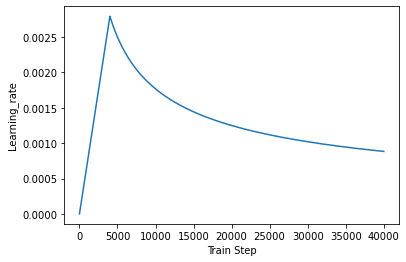

In [31]:
#Plots how the learning rate evolves with steps
plt.plot(learning_rating(tf.range(40000,dtype = tf.float32)))
plt.ylabel("Learning_rate")
plt.xlabel("Train Step")

In [32]:
#Test to see whether the transformer is currently accepting the inputs 
#and producing the desired outputs
output = ParticleTranformer((X_train,X_train_b_jets))
output

<tf.Tensor: shape=(45154, 9), dtype=float32, numpy=
array([[-1.5399098 ,  1.2009662 , -1.3766043 , ..., -1.7110934 ,
        -1.95137   ,  1.8228079 ],
       [ 1.1151946 , -2.7162232 , -1.0014962 , ...,  0.6829988 ,
         1.2919912 , -0.4600667 ],
       [ 1.3065096 , -2.9165664 , -0.6916702 , ...,  0.37771082,
         1.6642616 ,  0.42707208],
       ...,
       [-0.9089909 , -0.5407385 , -2.630772  , ..., -0.47060436,
         0.80856633, -0.96216846],
       [-1.4851725 ,  0.77033025, -2.4090362 , ..., -1.6537037 ,
        -1.0791326 ,  1.4020514 ],
       [ 0.11070459,  0.9760075 , -1.2908206 , ..., -1.532798  ,
         0.6781502 , -1.5208412 ]], dtype=float32)>

In [33]:
ParticleTranformer.summary()

Model: "hffrag_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  39968     
                                                                 
 b__jet__layer (B_Jet_Layer)  multiple                 3285      
                                                                 
Total params: 43,253
Trainable params: 43,253
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,  # The minimum amount of change to count as an improvement
    patience=30,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.80, patience=10, min_lr=1e-8)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints_2/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = ((X_train,X_train),y_train), validation_data = ((X_valid,X_valid,),y_valid), log_batch_frequency = 5)

In [35]:
# Train the neural network
Training_data = X_train
Validation_data = X_valid
history = ParticleTranformer.fit(
    (X_train, X_train_b_jets), y_train,
    validation_data=((X_valid,X_valid_b_jets),y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,cb,cp_callback]
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
706/706 [==============================] - 42s 37ms/step - loss: 12.8465 - val_loss: 2.7271 - lr: 1.0000e-04


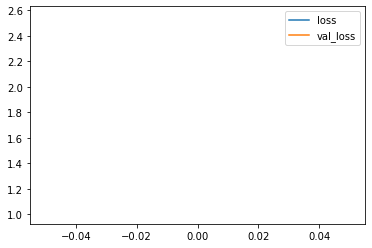

In [36]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [37]:
#Determine how long the training took in seconds.
print(sum(cb.logs))

41.82170066004619


In [38]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 12.846503257751465


In [39]:
#Evaluate the entire performance of the model
loss = ParticleTranformer.evaluate((tracks,tracks),bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

InvalidArgumentError: Graph execution error:

Detected at node 'hffrag_transformer/b__jet__layer/model/concatenate/concat' defined at (most recent call last):
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32695/3099961922.py", line 2, in <module>
      loss = ParticleTranformer.evaluate((tracks,tracks),bhads,verbose = 2)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 1756, in test_step
      y_pred = self(x, training=False)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/DeepLearningParticlePhysics/hffragTransformerJetMultivariate.py", line 265, in call
      Outputs = self.jet_layer(Jets,Embedding)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/DeepLearningParticlePhysics/hffragTransformerJetMultivariate.py", line 159, in call
      x = self.JetNet([x, context])
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/layers/merging/base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/layers/merging/concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'hffrag_transformer/b__jet__layer/model/concatenate/concat'
ConcatOp : Ranks of all input tensors should match: shape[0] = [32,32,8] vs. shape[1] = [32,32]
	 [[{{node hffrag_transformer/b__jet__layer/model/concatenate/concat}}]] [Op:__inference_test_function_34779]